In [1]:
import os
import flopy
import matplotlib.pyplot as plt
from flopy.plot import PlotMapView, styles
from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid
from flopy.discretization import VertexGrid
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString
import shapefile
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from dany import fill_sinks, FlowDirections, PrmsStreams

from gsflow.builder import GenerateFishnet

C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version

In [2]:
def build_grid_instance(shp):
    """

    Parameters
    ----------
    shp : str
    """
    verts = {}
    icverts = []
    xcyc = []
    ivcnt = 0
    with shapefile.Reader(shp) as r:
        for ix, shape in enumerate(r.shapes()):
            icv = []
            points = shape.points[::-1]
            poly = np.array(list(points))
            center = list(np.mean(poly, axis=0))
            xcyc.append(center)
            for vert in points:
                if vert in verts:
                    iv = verts[vert]
                    if iv not in icv:
                        icv.append(iv)
                else:
                    icv.append(ivcnt)
                    verts[vert] = ivcnt
                    ivcnt += 1

            icverts.append(icv)

        ncpl = len(icverts)
        cell2d = []
        for ix, (xc, yc) in enumerate(xcyc):
            iverts = icverts[ix]
            cell2d_rec = [ix, xc, yc, len(iverts)] + list(iverts)
            cell2d.append(cell2d_rec)

        verts = [[v, k[0], k[1]] for k, v in verts.items()]
        idomain = np.ones((ncpl,))
        top = np.ones((ncpl,))
        botm = np.ones((1, ncpl,))

        grid = flopy.discretization.VertexGrid(
            vertices=verts,
            cell2d=cell2d,
            top=top,
            botm=botm,
            idomain=idomain,
            nlay=1,
            ncpl=ncpl
        )
        return grid


def make_stream_mask(shp, modelgrid):
    gix = flopy.utils.GridIntersect(modelgrid)
    mask = np.zeros((modelgrid.ncpl,), dtype=int)
    with shapefile.Reader(shp) as r:
        for shape in r.shapes():
            result = gix.intersect(shape)
            cellids = result.cellids.astype(int)
            mask[cellids] = 1

    return mask


def get_grid_bounds(shp):
    with shapefile.Reader(shp) as r:
        bounds = r.bbox

    polygon = [
        (bounds[0], bounds[1]),
        (bounds[0], bounds[3]),
        (bounds[2], bounds[3]),
        (bounds[2], bounds[1]),
        (bounds[0], bounds[1])
    ]
    return [bounds[0], bounds[2], bounds[1], bounds[3]], polygon

In [3]:
ws = os.path.join(".")
data_ws = os.path.join(ws, "..", "data", "Lolo_Voronoi_Grid")
grid_shp = os.path.join(data_ws, "LoloCr_voronoiGrid.shp")
dem_file = os.path.join(data_ws, "USGS_13_lolo_utm.tif")
dem_ascii = os.path.join(data_ws, "USGS_13_lolo_utm_dem_ascii.csv")
fa_dem_grid_supplied = os.path.join(data_ws, "streams_grid_supplied_no_strm_correction.csv")

# use the existing vertex grid to get boundaries for defining a structured grid
vgrid = build_grid_instance(grid_shp)
bbox, bounds_polygon = get_grid_bounds(grid_shp)

Resample the DEM

In [4]:
pploc = (723400, 5181350)
sgrid = GenerateFishnet(bbox, xcellsize=250, ycellsize=250)

raster = flopy.utils.Raster.load(dem_file)
raster.crop(bounds_polygon)
dem = raster.resample_to_grid(sgrid, band=raster.bands[0], method="min")
dem = np.where(dem == raster.nodatavals[0], np.nan, dem)

C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\rasterstats\io.py:17: DeprecationWarning: ReadingError is deprecated and will be removed in a future version. Use ShapelyError instead (functions previously raising {name} will now raise a ShapelyError instead).
  from shapely.errors import ReadingError


Condition the DEM and run flow accumulation processes

In [5]:
conditioned_dem = fill_sinks(sgrid, dem)
fdir = FlowDirections(sgrid, conditioned_dem)
fdir.flow_directions()
facc = fdir.flow_accumulation()

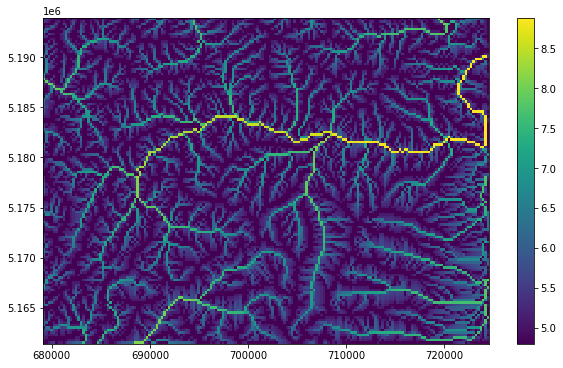

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
lfacc = np.log10(facc)
pc = pmv.plot_array(lfacc)
# pmv.plot_grid()
plt.colorbar(pc);

delineate watershed boundary based on pour point location

In [7]:
watershed = fdir.get_watershed_boundary(pploc)
facc[watershed == 0] = np.nan

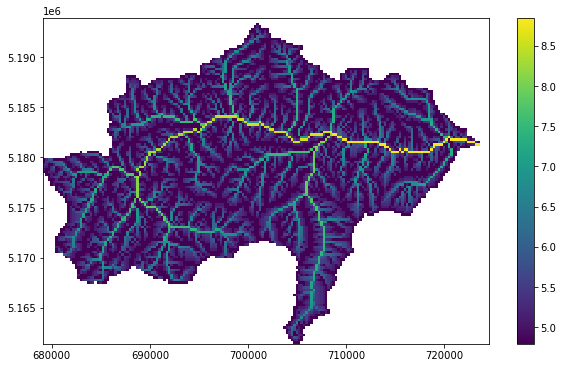

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
lfacc = np.log10(facc)
pc = pmv.plot_array(lfacc)
# pmv.plot_grid()
plt.colorbar(pc);

Delineate the structured stream locations and create vectors

In [9]:
strms = PrmsStreams(sgrid, fdir)
strm_array = strms.delineate_streams(contrib_area=6e6).astype(float)
strm_array[watershed == 0] = np.nan
vectors = strms.create_stream_vectors(strm_array)

Plot these vectors with the stream array

In [10]:
geom = [LineString(v) for v in vectors.values()]
segs = [k for k in vectors.keys()]
gdf = gpd.GeoDataFrame({"geometry": geom, "segments": segs})
gdf = gdf.dissolve()
gdf["geometry"] = gdf.geometry.buffer(100, cap_style=2, join_style=3) # 1 for round, 2 flat/mitre, 3 square/bevel

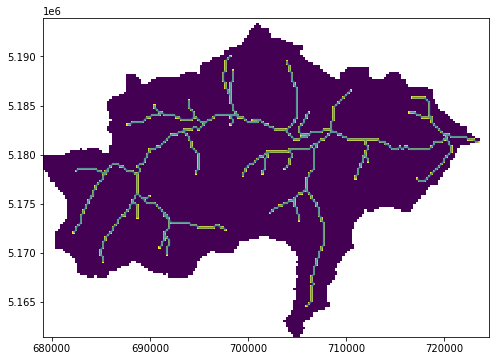

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
strm_array[watershed == 0] = np.nan
pc = pmv.plot_array(strm_array)
gdf.plot(ax=ax, alpha=0.75);

Create a geodataframe of the active watershed and dissolve it

In [12]:
sgdf = sgrid.geo_dataframe
iloc = np.where(watershed.ravel() > 0)[0]
sgdf = sgdf.iloc[iloc]
sgdf = sgdf.dissolve()

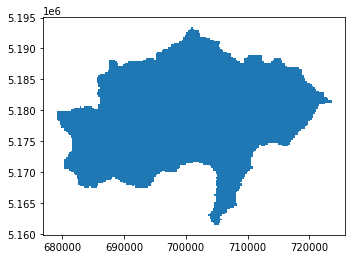

In [13]:
sgdf.plot();

Trim the buffered stream vectors by overlaying with the active watershed

In [14]:
igdf = gpd.overlay(gdf, sgdf, how="intersection")
# igdf = gdf.copy()

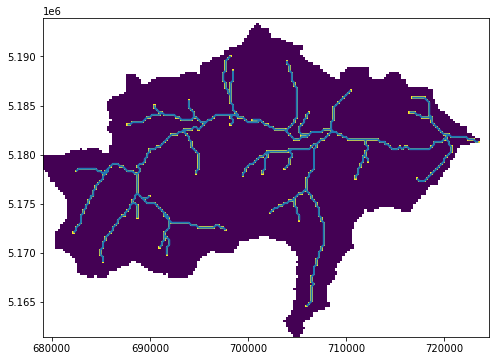

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
strm_array[watershed == 0] = np.nan
pc = pmv.plot_array(strm_array)
igdf.plot(ax=ax);

Generate a triangular mesh using the `Triangle` module

Note: Must define a watershed point `wsloc` and a stream refinement point `srloc`

In [16]:
wsloc = (710000, 5172000)
srloc = (712000, 5181600)

In [17]:
tri_ws = os.path.join(ws, "..", "data", "triangle_grid")
tri = flopy.utils.triangle.Triangle(angle=20, model_ws=tri_ws)
tri.add_polygon(sgdf.geometry.values[0])
tri.add_polygon(gdf.geometry.values[0], ignore_holes=True)
tri.add_region(wsloc, 0, maximum_area=250*250*10)
tri.add_region(pploc, 1, maximum_area=250*250*0.5)
tri.build()

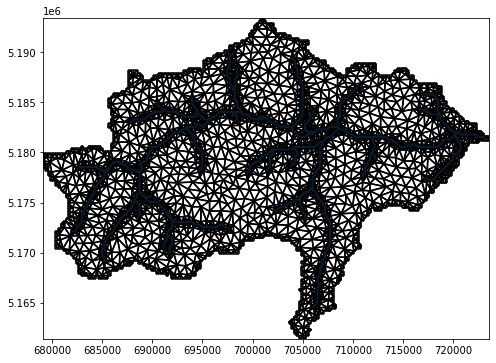

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
tri.plot(ax=ax)
igdf.geometry.plot(ax=ax, alpha=0.25, zorder=5);

Now generate a voronoi mesh from the triangular mesh

In [19]:
vor = VoronoiGrid(tri)
gridprops = vor.get_gridprops_vertexgrid()
vgrid = VertexGrid(nlay=1, **gridprops)

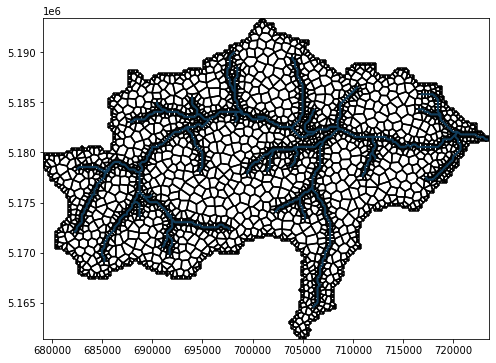

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
pmv = PlotMapView(modelgrid=vgrid, ax=ax)
pmv.plot_grid(color="k")
igdf.geometry.plot(ax=ax, alpha=0.50, zorder=5);

Now we can begin the process of performing raster resampling and flow accumulation on the voronoi grid

In [21]:
raster = flopy.utils.Raster.load(dem_file)
raster.crop(bounds_polygon)
dem = raster.resample_to_grid(vgrid, band=raster.bands[0], method="min")
dem = np.where(dem == raster.nodatavals[0], np.nan, dem)

In [22]:
conditioned_dem = fill_sinks(vgrid, dem)

# perform area based flow accumulation
fdir = FlowDirections(vgrid, conditioned_dem)
fdir.flow_directions()
facc = fdir.flow_accumulation()
# perform cellular flow accumulation
fdir2 = FlowDirections(vgrid, conditioned_dem)
fdir2.flow_directions()
facc2 = fdir2.flow_accumulation(as_cells=True)

running dijkstra
running dijkstra
running dijkstra
running dijkstra
running dijkstra
running dijkstra
running dijkstra
running dijkstra
running dijkstra
running dijkstra
running dijkstra
running dijkstra
running dijkstra
running dijkstra
running dijkstra
running dijkstra
running dijkstra
running dijkstra
running dijkstra
running dijkstra


Examine the area based flow accumulation

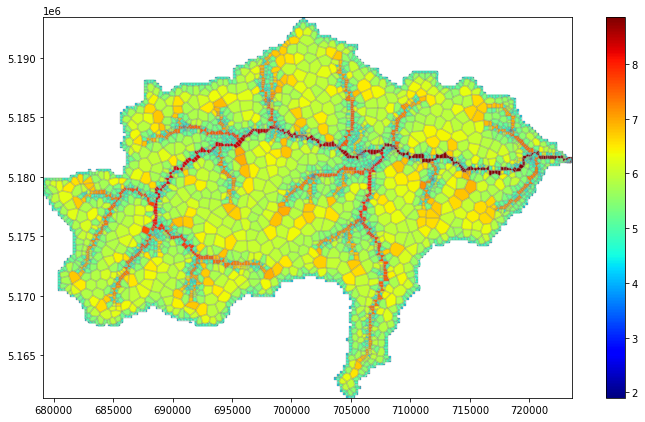

In [23]:
fig, ax = plt.subplots(figsize=(12, 7))
pmv = PlotMapView(modelgrid=vgrid)
lfacc = np.log10(facc)
pc = pmv.plot_array(lfacc, alpha=1.0, cmap="jet")
pmv.plot_grid(alpha=0.2)
plt.colorbar(pc);

Examine the cellular based flow accumulation

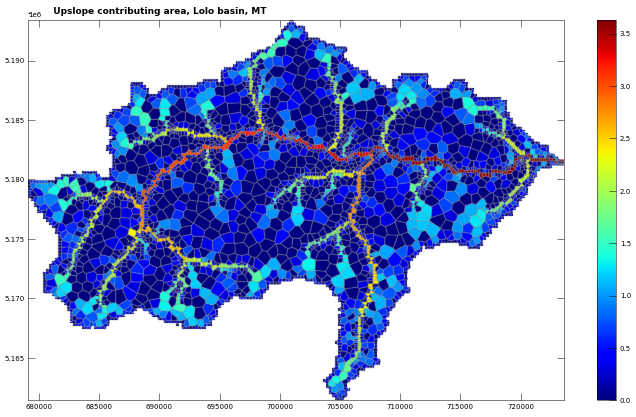

In [24]:
with styles.USGSPlot():
    fig, ax = plt.subplots(figsize=(12, 7))
    pmv = PlotMapView(modelgrid=vgrid, ax=ax)
    lfacc2 = np.log10(facc2)
    pc = pmv.plot_array(lfacc2, alpha=1.0, cmap="jet")
    pmv.plot_grid(alpha=0.2)
    plt.colorbar(pc)
    styles.heading(ax=ax, letter="", heading="      Upslope contributing area, Lolo basin, MT")
    plt.savefig("Lolo_contributing_area.png");

Threshold the unstructured stream network for area based flow accumulation

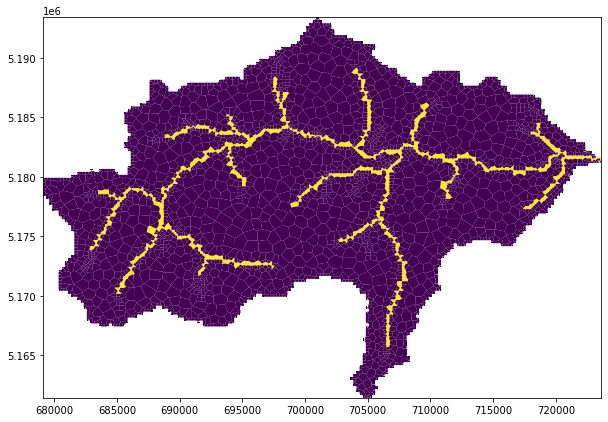

In [25]:
strms = PrmsStreams(vgrid, fdir)
stream_array = strms.delineate_streams(contrib_area=1e7)

fig, ax = plt.subplots(figsize=(10, 7))
pmv = PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(stream_array);

Threshold the cellular based flow accumulation for comparison

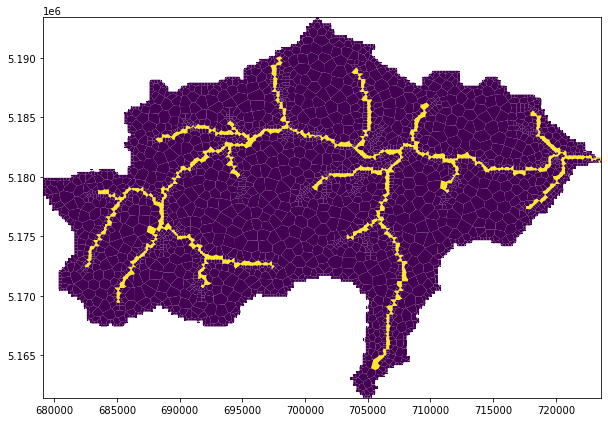

In [26]:
strms2 = PrmsStreams(vgrid, fdir2)
stream_array2 = strms2.delineate_streams(contrib_area=4.7e1)

fig, ax = plt.subplots(figsize=(10, 7))
pmv = PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(stream_array2);

Create a graph of stream linkages with `PrmsStreams`

In [27]:
strm_conn = strms.get_stream_connectivity(stream_array, group_segments=True)
print(strm_conn)
print(np.min(stream_array), np.max(stream_array))

{26: 27, 24: 25, 23: 32, 22: 37, 19: 20, 18: 21, 15: 16, 14: 16, 13: 17, 12: 27, 11: 20, 10: 29, 8: 9, 7: 34, 5: 6, 4: 25, 3: 9, 2: 35, 1: 6, 27: 28, 30: 31, 6: 30, 25: 31, 32: 33, 34: 35, 36: 37, 9: 36, 37: 38, 38: 38, 21: 33, 20: 21, 33: 34, 16: 17, 17: 28, 31: 32, 35: 36, 28: 29, 29: 30}
0 38


generate many to one cascade linkages with `PrmsStreams`

In [28]:
hru_up, hru_down, hru_pct_up, hru_strmseg_down = strms.get_cascades(stream_array=stream_array)

or generate many to many cascade linkages with `PrmsStreams`

In [29]:
hru_up, hru_down, hru_pct_up, hru_strmseg_down = strms.get_cascades(stream_array=stream_array, many2many=True)

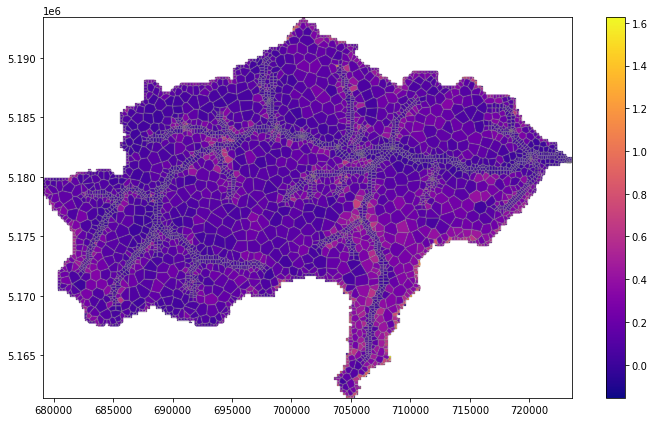

In [30]:
slope = fdir.slope

fig, ax = plt.subplots(figsize=(12, 7))
pmv = PlotMapView(modelgrid=vgrid)
pc = pmv.plot_array(slope, alpha=1.0, cmap="plasma")
pmv.plot_grid(alpha=0.2)
plt.colorbar(pc);

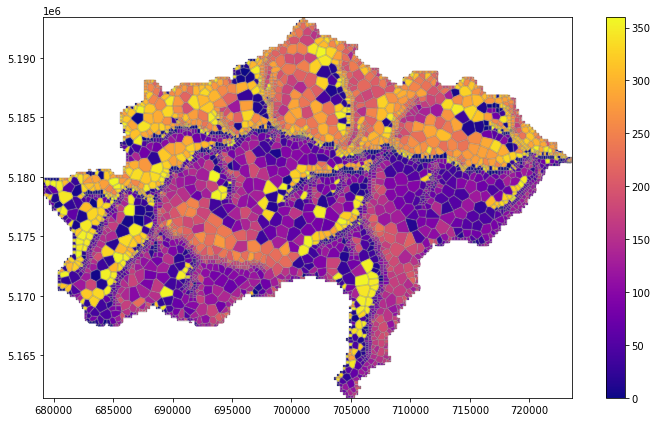

In [31]:
aspect = fdir.aspect

fig, ax = plt.subplots(figsize=(12, 7))
pmv = PlotMapView(modelgrid=vgrid)
pc = pmv.plot_array(aspect, alpha=1.0, cmap="plasma")
pmv.plot_grid(alpha=0.2)
plt.colorbar(pc);

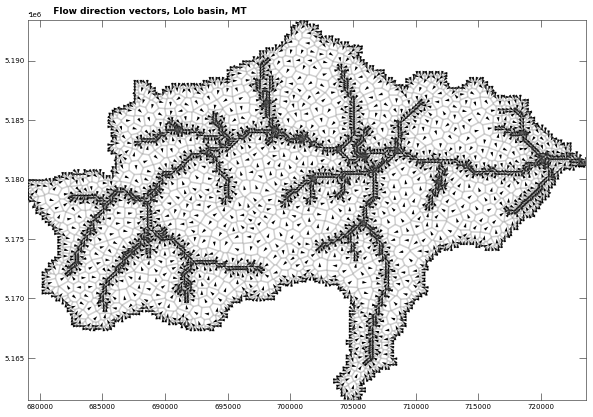

In [32]:
u, v = fdir.vectors

with styles.USGSPlot():
    fig, ax = plt.subplots(figsize=(10, 7))
    pmv = PlotMapView(modelgrid=vgrid, ax=ax)
    pc = pmv.plot_vector(u, v)
    pmv.plot_grid(alpha=0.2)
    # plt.colorbar(pc)
    styles.heading(ax=ax, letter="", heading="      Flow direction vectors, Lolo basin, MT")
    plt.savefig("Lolo_flow_vectors.png");